In [124]:
import numpy as np
import pandas as pd
import os
from datetime import datetime

Project of predicting the time of a running activity

# Load data

In [125]:
# Extract project df
PROJECT_URL = 'https://raw.githubusercontent.com/AdrianSzymczyk/running-ml-project/main/data/activity_log.csv'
df = pd.read_csv(PROJECT_URL)
df.head()

,Activity Type,Date,Title,Distance,Calories,Time,Avg HR,Max HR,Avg Run Cadence,Max Run Cadence,Avg Pace,Best Pace,Elev Gain,Elev Loss,Avg Stride Length,Best Lap Time,Number of Laps
0,Running,7/15/20 9:41,Cherry Hill Running,6.00,530,0:43:55,141,160,176,182,7:19,6:20,169,173,1.26,00:02.3,7
1,Running,7/14/20 17:45,Cherry Hill Running,6.50,587,0:47:04,144,160,172,182,7:14,6:35,183,187,1.29,03:32.7,7
2,Running,7/13/20 18:57,Cherry Hill Running,5.01,392,0:40:29,128,151,170,180,8:05,5:49,124,124,1.17,00:04.1,6
3,Running,7/12/20 18:44,Cherry Hill Running,7.01,633,0:52:55,142,157,172,180,7:33,5:00,215,219,1.24,00:05.1,8
4,Running,7/11/20 19:35,Cherry Hill Running,5.19,419,0:41:35,129,143,170,178,8:01,6:48,76,80,1.18,01:27.1,6


In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689 entries, 0 to 688
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Activity Type      689 non-null    object 
 1   Date               689 non-null    object 
 2   Title              689 non-null    object 
 3   Distance           689 non-null    float64
 4   Calories           689 non-null    object 
 5   Time               689 non-null    object 
 6   Avg HR             689 non-null    object 
 7   Max HR             689 non-null    object 
 8   Avg Run Cadence    689 non-null    object 
 9   Max Run Cadence    689 non-null    object 
 10  Avg Pace           689 non-null    object 
 11  Best Pace          689 non-null    object 
 12  Elev Gain          689 non-null    object 
 13  Elev Loss          689 non-null    object 
 14  Avg Stride Length  689 non-null    float64
 15  Best Lap Time      689 non-null    object 
 16  Number of Laps     689 non

# Preprocessing

### Delete rows with missing values 

In [127]:
df = df[~df[['Distance', 'Avg HR', 'Max HR', 'Avg Pace', 'Avg Run Cadence', 'Elev Gain', 'Elev Loss']].isin(['--']).any(axis=1)].reset_index(drop=True)

#### Reset indices after deleting rows

## Convert Avg HR Max HR columns into numeric type

In [128]:
df['Elev Gain'] = df['Elev Gain'].apply(lambda x: int(str(x).replace(',', '')))
df['Elev Loss'] = df['Elev Loss'].apply(lambda x: int(str(x).replace(',', '')))
df['Calories'] = df['Calories'].apply(lambda x: int(str(x).replace(',', '')))

In [129]:
df['Calories'] = df['Calories'].astype(int)
df['Avg HR'] = df['Avg HR'].astype(int)
df['Max HR'] = df['Max HR'].astype(int)
df['Avg Run Cadence'] = df['Avg Run Cadence'].astype(int)
df['Max Run Cadence'] = df['Max Run Cadence'].astype(int)
df['Elev Gain'] = df['Elev Gain'].astype(float)
df['Elev Loss'] = df['Elev Loss'].astype(float)

### Fix problem with Time shorter than 10 minutes

#### Convert column Time values with format %M:%S.%MS to format %H:%M:%S

In [130]:
invalid_time_indices = df[df['Time'].apply(lambda x: x[-2] == '.')].index

In [131]:
df['Time'] = df['Time'].apply(lambda x: datetime.strptime(x, '%M:%S.%f').time() if x[-2] == '.' else datetime.strptime(x, '%H:%M:%S').time())

### Convert Time into numeric representation as total number of seconds

In [132]:
df['Time'] = pd.to_timedelta(df['Time'].astype(str)).dt.total_seconds().astype(int)

#### Avg Pace conversion

In [133]:
df['Avg Pace'] = df['Avg Pace'].apply(pace_to_km)

#### Best Pace conversion

In [134]:
df['Best Pace'] = df['Best Pace'].apply(pace_to_km)

### Convert data units from Miles to Kilometers

#### Distance conversion

In [135]:
df['Distance'] = df['Distance'].apply(lambda x: round(x * 1.60934, 2))

#### Pace conversion 

In [136]:
def pace_to_km(pace):
    mile = 1.60934 
    minutes, seconds = pace.split(':')
    pace_in_seconds = int(minutes) * 60 + int(seconds)
    pace_per_km = round(pace_in_seconds / mile)
    return pace_per_km

## Drop columns which won't be usefull for out regression

In [137]:
df_for_model = df.drop(['Activity Type', 'Date', 'Title', 'Best Lap Time', 'Number of Laps', 'Best Pace'], axis=1)

In [138]:
df_for_model.head()

,Distance,Calories,Time,Avg HR,Max HR,Avg Run Cadence,Max Run Cadence,Avg Pace,Elev Gain,Elev Loss,Avg Stride Length
0,9.66,530,2635,141,160,176,182,273,169.0,173.0,1.26
1,10.46,587,2824,144,160,172,182,270,183.0,187.0,1.29
2,8.06,392,2429,128,151,170,180,301,124.0,124.0,1.17
3,11.28,633,3175,142,157,172,180,281,215.0,219.0,1.24
4,8.35,419,2495,129,143,170,178,299,76.0,80.0,1.18


## Looking for Correlations

In [139]:
df_for_model.describe()

,Distance,Calories,Time,Avg HR,Max HR,Avg Run Cadence,Max Run Cadence,Avg Pace,Elev Gain,Elev Loss,Avg Stride Length
count,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.000000,634.00000
mean,8.499543,421.746057,2234.938486,144.457413,165.668770,177.037855,189.063091,258.143533,264.821767,265.157729,1.34082
std,6.263989,300.780601,1628.836675,14.036251,15.044665,7.085251,10.158264,38.750140,276.334467,277.648169,0.17664
min,0.400000,7.000000,66.000000,102.000000,116.000000,162.000000,168.000000,160.000000,3.000000,3.000000,0.90000
25%,3.400000,177.500000,919.250000,135.000000,156.000000,172.000000,180.000000,249.000000,63.000000,59.000000,1.25000
50%,6.570000,379.000000,1822.000000,143.000000,165.000000,176.000000,188.000000,264.000000,153.000000,148.500000,1.29500
75%,12.860000,610.000000,3327.250000,152.000000,176.000000,180.000000,194.000000,279.000000,403.750000,397.750000,1.36000
max,28.980000,1654.000000,7200.000000,188.000000,209.000000,202.000000,246.000000,400.000000,1262.000000,1521.000000,1.86000


In [140]:
corr_matrix = df_for_model.corr(numeric_only=True)

In [141]:
corr_matrix['Time'].sort_values(ascending=False)

Time                 1.000000
Distance             0.992891
Calories             0.955622
Elev Gain            0.821551
Elev Loss            0.818582
Avg Pace             0.252870
Max HR               0.134543
Avg HR              -0.053432
Max Run Cadence     -0.178102
Avg Stride Length   -0.319321
Avg Run Cadence     -0.331184
Name: Time, dtype: float64

# Split dataset

In [142]:
from sklearn.model_selection import train_test_split

def get_data_splits(X, y, train_size=0.7):
    X_train, X_, y_train, y_ = train_test_split(X, y, train_size=train_size, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [143]:
X_train, X_val, X_test, y_train, y_val, y_test = get_data_splits(X=df_for_model.drop('Time', axis=1), y=df_for_model['Time'])

# Train, adjust hyperparameters and evaluate models

## -->Linear Regression

In [144]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

lin_reg = LinearRegression()
# Train model on the training set
lin_reg.fit(X_train, y_train)
# Predict values 
y_pred = lin_reg.predict(X_test)
# Evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean squared error: {mse:.2f} seconds')
print(f'Mean absolute error: {mae:.2f} seconds')

Mean squared error: 123.09 seconds
Mean absolute error: 87.63 seconds


In [145]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lin_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
scores = np.sqrt(-scores)
print('Outcomes:', scores)
print('Mean:', scores.mean())
print('Standard deviation:', scores.std())

Outcomes: [111.26083732 135.6175408  116.75448959 156.96834224 141.54296541
 117.27024139 106.41079103 180.81606197 105.08903385 107.47253924]
Mean: 127.92028428428975
Standard deviation: 24.09200759322915


### <u> Linear Regression with PolynomialFeature </u> BEST ONE

In [146]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

polynomial_regression = make_pipeline(
    PolynomialFeatures(include_bias=False),
    StandardScaler(),
    LinearRegression()
)
# Train model on training set
polynomial_regression.fit(X_train, y_train)
# Predict valeus 
y_pred = polynomial_regression.predict(X_test)
# Evalueate the model on the test set
mse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean squared error: {mse:.2f} seconds')
print(f'Mean absolute error: {mae:.2f} seconds')

scores = cross_val_score(polynomial_regression, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
scores = np.sqrt(-scores)
print('\nOutcomes:', scores)
print('Mean:', scores.mean())
print('Standard deviation:', scores.std())

Mean squared error: 4.94 seconds
Mean absolute error: 3.55 seconds

Outcomes: [2.4097625  6.52823458 4.54182088 5.81777243 5.42498357 4.2994862
 3.07439461 5.11304174 4.24435201 4.5800948 ]
Mean: 4.603394332413428
Standard deviation: 1.1614620087993124


In [25]:
pd.DataFrame({'y_test': y_test.values, 'y_pred': y_pred}).head()

,y_test,y_pred
0,178,178.565962
1,2323,2323.377057
2,2387,2384.067641
3,3333,3331.161803
4,888,888.036804


In [26]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scaler', StandardScaler()),
    ('linear', LinearRegression())
])

param_grid = {
    'poly__degree': [1,2,3,4]
}
# Create a GridSearchCV object with pipeline and hyperparamters to search over
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# Train the grid search on training set
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding mean squared error
print("Best hyperparameters: ", grid_search.best_params_)
print("Best MSE: ", np.sqrt(-grid_search.best_score_))

Best hyperparameters:  {'poly__degree': 2}
Best MSE:  5.405348314305393


## --> SVM

In [27]:
from sklearn.svm import SVR

svm_reg_pipe = make_pipeline(
    StandardScaler(),
    SVR()
)
svm_reg = SVR()
# Train model on training set
svm_reg_pipe.fit(X_train, y_train)
y_pred = svm_reg_pipe.predict(X_test)
# Evalueate the model on the test set
mse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean squared error: {mse:.2f} seconds')
print(f'Mean absolute error: {mae:.2f} seconds')

scores = cross_val_score(svm_reg_pipe, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
scores = np.sqrt(-scores)
print('\nOutcomes:', scores)
print('Mean:', scores.mean())
print('Standard deviation:', scores.std())

Mean squared error: 1752.09 seconds
Mean absolute error: 1352.38 seconds

Outcomes: [1463.38583766 1668.56549134 1458.48011337 1899.08778814 1634.39489456
 1498.1952712  1882.60971203 1885.11979069 1612.33029929 1825.51476271]
Mean: 1682.7683960991685
Standard deviation: 169.72261657888671


## --> RandomForest

In [28]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=42)
)
# Train model on training set
forest_reg.fit(X_train, y_train)
y_pred = forest_reg.predict(X_test)
# Evalueate the model on the test set
mse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean squared error: {mse:.2f} seconds')
print(f'Mean absolute error: {mae:.2f} seconds')

scores = cross_val_score(forest_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
scores = np.sqrt(-scores)
print('\nOutcomes:', scores)
print('Mean:', scores.mean())
print('Standard deviation:', scores.std())

Mean squared error: 99.85 seconds
Mean absolute error: 63.72 seconds

Outcomes: [ 97.44426657  79.68426797  89.23167184 163.50320648 137.90629646
 115.21141868 113.43881191 184.63416597 106.26859622 133.76336014]
Mean: 122.10860622454797
Standard deviation: 31.4182244010454


In [29]:
pd.DataFrame({'y_test': y_test.values, 'y_pred': y_pred}).head()

,y_test,y_pred
0,178,179.82
1,2323,2373.75
2,2387,2356.00
3,3333,3316.33
4,888,880.15


## --> Stochastic Gradient Descent

In [30]:
from sklearn.linear_model import SGDRegressor

# Train model on training set
sgd_reg = SGDRegressor()
sgd_reg.fit(X_train, y_train)
y_pred = sgd_reg.predict(X_test)
# Evalueate the model on the test set
mse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean squared error: {mse:.2f} seconds')
print(f'Mean absolute error: {mae:.2f} seconds')

Mean squared error: 555351423880402.25 seconds
Mean absolute error: 401307243498854.19 seconds


In [31]:
param_grid = {
    'alpha': 10.0 ** -np.arange(1, 7),
    'loss': ['huber', 'epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'invscaling'],
    'eta0': 10.0 ** -np.arange(1, 4),
    'power_t': np.arange(0, 2, 0.25),
    'max_iter': np.arange(1000, 10000, 1000),
}
model = SGDRegressor()
rnd_search = RandomizedSearchCV(model, param_grid)
rnd_search.fit(X_train, y_train)
print('Best hyperparamenters: ', rnd_search.best_params_)
print("Best MSE: ", rnd_search.best_score_)

Best hyperparamenters:  {'power_t': 0.25, 'penalty': 'l2', 'max_iter': 4000, 'loss': 'epsilon_insensitive', 'learning_rate': 'constant', 'eta0': 0.001, 'alpha': 0.001}
Best MSE:  0.8948497032185945


In [35]:
model = SGDRegressor(
    loss='huber', penalty='l2', alpha=1e-05, max_iter=9000,
    learning_rate='invscaling', eta0=0.01, power_t=0.25,
    warm_start=True)

In [33]:
model = SGDRegressor(**rnd_search.best_params_)

Epoch: 00 | train_mse: 183687.12640, val_mse: 174286.47211
Epoch: 10 | train_mse: 138561.26237, val_mse: 140535.21575
Epoch: 20 | train_mse: 135294.16132, val_mse: 145528.05680
Epoch: 30 | train_mse: 163137.43817, val_mse: 182188.87248
Epoch: 40 | train_mse: 117340.36812, val_mse: 119386.84121
Epoch: 50 | train_mse: 119770.99464, val_mse: 131677.56914
Epoch: 60 | train_mse: 112350.16549, val_mse: 125362.27965
Epoch: 70 | train_mse: 94580.39761, val_mse: 103537.21024
Epoch: 80 | train_mse: 91545.40585, val_mse: 91224.75233
Epoch: 90 | train_mse: 174558.96443, val_mse: 199857.76730
Epoch: 100 | train_mse: 74812.77639, val_mse: 76471.81931
Epoch: 110 | train_mse: 97964.47460, val_mse: 114128.33726
Epoch: 120 | train_mse: 68706.26892, val_mse: 72289.22739
Epoch: 130 | train_mse: 60921.59940, val_mse: 67851.72584
Epoch: 140 | train_mse: 61492.43948, val_mse: 59708.97303
Epoch: 150 | train_mse: 95278.82588, val_mse: 81259.98814
Epoch: 160 | train_mse: 50053.73953, val_mse: 60099.00917
Epoch:

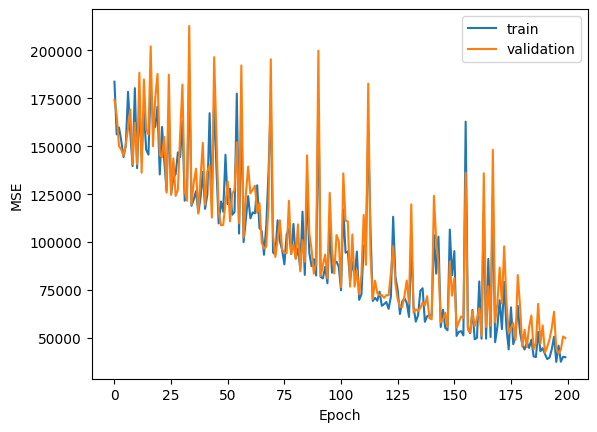

In [36]:
import matplotlib.pyplot as plt

num_epochs = 200
train_mse = []
val_mse = []

for epoch in range(num_epochs):
    # Training
    model.fit(X_train, y_train)

    # Evaluation
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)    
    train_mse.append(mean_squared_error(y_train, train_pred))
    val_mse.append(mean_squared_error(y_val, val_pred))
    
    if not epoch%10:
        print(
            f"Epoch: {epoch:02d} | "
            f"train_mse: {train_mse[-1]:.5f}, "
            f"val_mse: {val_mse[-1]:.5f}"
        )

# Plot the MSE for each epoch
plt.plot(train_mse, label='train')
plt.plot(val_mse, label='validation')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

## Testing models with different combination of features

In [37]:
df.corr(numeric_only=True)['Calories'].sort_values(ascending=False)

Calories             1.000000
Time                 0.955622
Distance             0.950508
Number of Laps       0.944696
Elev Gain            0.767314
Elev Loss            0.763612
Avg Pace             0.242882
Max HR               0.236209
Avg HR               0.104829
Best Pace            0.054429
Max Run Cadence     -0.216974
Avg Stride Length   -0.299361
Avg Run Cadence     -0.366149
Name: Calories, dtype: float64

In [38]:
new_df = df_for_model.drop(['Max HR', 'Best Pace', 'Max Run Cadence', 'Avg Stride Length'], axis=1)

In [39]:
new_df.head()

,Distance,Calories,Time,Avg HR,Avg Run Cadence,Avg Pace,Elev Gain,Elev Loss
0,9.66,530,2635,141,176,273,169.0,173.0
1,10.46,587,2824,144,172,270,183.0,187.0
2,8.06,392,2429,128,170,301,124.0,124.0
3,11.28,633,3175,142,172,281,215.0,219.0
4,8.35,419,2495,129,170,299,76.0,80.0


In [40]:
X_train, X_val, X_test, y_train, y_val, y_test = get_data_splits(X=new_df.drop('Calories', axis=1), y=new_df['Calories'])

### Linear Regression

In [41]:
lin_reg = LinearRegression()
# Train model on the training set
lin_reg.fit(X_train, y_train)
# Predict values 
y_pred = lin_reg.predict(X_test)
# Evaluate the model on the test set
mse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean squared error: {mse:.2f} calories')
print(f'Mean absolute error: {mae:.2f} calories')

scores = cross_val_score(lin_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
scores = np.sqrt(-scores)
print('\nOutcomes:', scores)
print('Mean:', scores.mean())
print('Standard deviation:', scores.std())

Mean squared error: 64.12 calories
Mean absolute error: 44.54 calories

Outcomes: [57.92225573 93.5023716  58.70922722 86.02391241 92.60274924 68.03373995
 64.38318104 82.15636907 87.38622441 68.67914931]
Mean: 75.93991799660951
Standard deviation: 13.144414404180528


### Linear Regression with Polynomial Features

In [42]:
polynomial_regression = make_pipeline(
    PolynomialFeatures(include_bias=False),
    StandardScaler(),
    LinearRegression()
)
# Train model on training set
polynomial_regression.fit(X_train, y_train)
# Predict valeus 
y_pred = polynomial_regression.predict(X_test)
# Evalueate the model on the test set
mse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean squared error: {mse:.2f} calories')
print(f'Mean absolute error: {mae:.2f} calories')

scores = cross_val_score(polynomial_regression, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
scores = np.sqrt(-scores)
print('\nOutcomes:', scores)
print('Mean:', scores.mean())
print('Standard deviation:', scores.std())

Mean squared error: 45.39 calories
Mean absolute error: 29.73 calories

Outcomes: [37.22197739 50.341404   31.87968289 44.14693276 46.37864098 40.59431664
 42.49243655 48.20695616 56.68468381 50.21788391]
Mean: 44.81649150926388
Standard deviation: 6.805903400856608


In [43]:
pd.DataFrame({'y_test': y_test.values, 'y_pred': y_pred}).head()

,y_test,y_pred
0,29,34.472443
1,506,459.723263
2,440,427.809020
3,808,892.003966
4,163,166.039333


### -->SVM Regressor

In [61]:
from sklearn.svm import SVR

svm_reg_pipe = make_pipeline(
    StandardScaler(),
    SVR()
)
# Train model on training set
svm_reg_pipe.fit(X_train, y_train)
y_pred = svm_reg_pipe.predict(X_test)
# Evalueate the model on the test set
mse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean squared error: {mse:.2f} calories')
print(f'Mean absolute error: {mae:.2f} calories')

scores = cross_val_score(svm_reg_pipe, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
scores = np.sqrt(-scores)
print('\nOutcomes:', scores)
print('Mean:', scores.mean())
print('Standard deviation:', scores.std())

Mean squared error: 282.78 calories
Mean absolute error: 214.50 calories

Outcomes: [223.10835328 330.17757264 246.94185521 301.31299113 253.37620159
 257.45625399 295.986131   324.50230541 270.12568411 277.02739194]
Mean: 278.00147402889166
Standard deviation: 32.89527160547896


### -->RandomForest Regressor

In [83]:
forest_reg = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(n_estimators=500, min_samples_leaf=1, random_state=42)
)
# Train model on training set
forest_reg.fit(X_train, y_train)
y_pred = forest_reg.predict(X_test)
# Evalueate the model on the test set
mse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean squared error: {mse:.2f} calories')
print(f'Mean absolute error: {mae:.2f} calories')

# scores = cross_val_score(forest_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
# scores = np.sqrt(-scores)
# print('\nOutcomes:', scores)
# print('Mean:', scores.mean())
# print('Standard deviation:', scores.std())

Mean squared error: 57.58 calories
Mean absolute error: 36.54 calories


In [46]:
pd.DataFrame({'y_test': y_test.values, 'y_pred': y_pred}).head()

,y_test,y_pred
0,29,22.53
1,506,471.82
2,440,422.23
3,808,720.70
4,163,166.05


In [68]:
# Define the hyperparameter parameters
params = {
    'n_estimators': np.arange(100, 1000, 100),
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [1.0, 'log2', 'sqrt'],
    'bootstrap': [True, False]
}

# Create the Random Forest Regressor object
rf_reg = RandomForestRegressor(random_state=42)
# Create the RandomizedSearchCV object
rs_reg = GridSearchCV(rf_reg, params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# Train the RandomizedSearchCV object on the training set
rs_reg.fit(X_train, y_train)

# Print the best hyperparameters found
print('Best Hyperparameters:', rs_reg.best_params_)
print('Best Score:', rs_reg.best_score_)

Best Hyperparameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}
Best Score: -3061.2560565306753


In [69]:
forest_reg_best_params = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(**rs_reg.best_params_)
)
# Train model on training set
forest_reg_best_params.fit(X_train, y_train)
y_pred = forest_reg_best_params.predict(X_test)
# Evalueate the model on the test set
mse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean squared error: {mse:.2f} calories')
print(f'Mean absolute error: {mae:.2f} calories')

scores = cross_val_score(forest_reg_best_params, X_train, y_train, scoring='neg_mean_squared_error', cv=10)
scores = np.sqrt(-scores)
print('\nOutcomes:', scores)
print('Mean:', scores.mean())
print('Standard deviation:', scores.std())

Mean squared error: 61.01 calories
Mean absolute error: 38.11 calories

Outcomes: [28.70346378 87.43988601 46.61296396 64.0412089  47.27718239 53.80995253
 43.1893268  50.15974648 48.23187139 54.24153121]
Mean: 52.37071334573564
Standard deviation: 14.481606922788176


## Testing models on new data

In [50]:
import pandas as pd

data = {'Distance': [10.5, 8.2, 12.4, 6.7, 9.3],
        'Time': [89.25, 74.5, 95.4, 55.7, 81.9],
        'Avg HR': [135, 142, 149, 128, 133],
        'Avg Run Cadence': [174, 168, 180, 182, 177],
        'Avg Pace': [8.5, 9.1, 7.8, 8.3, 8.8],
        'Elev Gain': [120, 70, 200, 30, 300],
        'Elev Loss': [110, 80, 220, 40, 280]
}

new_test_data = pd.DataFrame(data)
new_test_data['Time'] = 60 * new_test_data['Time']
new_test_data['Avg Pace'] = 60 * new_test_data['Avg Pace']
new_test_data

,Distance,Time,Avg HR,Avg Run Cadence,Avg Pace,Elev Gain,Elev Loss
0,10.5,5355.0,135,174,510.0,120,110
1,8.2,4470.0,142,168,546.0,70,80
2,12.4,5724.0,149,180,468.0,200,220
3,6.7,3342.0,128,182,498.0,30,40
4,9.3,4914.0,133,177,528.0,300,280


In [87]:
predict_calories_pol = polynomial_regression.predict(new_test_data)
predict_calories_forest = forest_reg.predict(new_test_data)
predict_calories_forest_rs = forest_reg_best_params.predict(new_test_data)
print(f'''
Polynomial regressor: {predict_calories_pol} 
RandomForest regressor: {predict_calories_forest}
RandomForest regressor with best params: {predict_calories_forest_rs}
''')


Polynomial regressor: [166.2154024  355.96136895 334.37437688 -60.11809234  99.69084471] 
RandomForest regressor: [692.37033333 633.16356081 928.1343746  388.6766     605.924     ]
RandomForest regressor with best params: [703.68406587 600.97300794 943.31806587 386.66032778 612.05442302]

